# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

Task: mapping a 1-D signal in time onto another 1-D signal.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of DTP-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=14,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

In [20]:
# simulation settings

dt = 0.01 # in ms
tauxi = 10 * dt
Tpres = 100 * dt
num_Tpres = 1000 * Tpres # total simulation time

In [51]:
np.random.seed(123)

# Init model: weights, voltages

layers = [1, 1, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0]
eta_bw = [0.0]
eta_PI = [50.0]
eta_IP = [40.0]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.normal(0, 1, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.normal(0, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.normal(0, 1, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.normal(0, 1, size=(layers[i], layers[-1])))

In [52]:
# input rates: random inputs

r0_random = np.random.uniform(0, 1, size=(int(num_Tpres / dt), layers[0]))

In [53]:
mc1 = model(dt, tauxi, Tpres, 'FA', relu, d_relu, layers, uP_init, uI_init, WPP_init, WIP_init, BPP_init, BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

In [54]:
mc1.WPP

[array([[-1.50629471]]), array([[-0.57860025]])]

In [55]:
mc1.evolve_system(r0_random[0])

In [56]:
mc1.BPI

[array([[-0.06930206]])]

## Test self-predicting dynamics (no target)

In [57]:
# mc1.set_self_predicting_state()

In [58]:
mc1.get_voltages()

([array([-1.0856098]), array([0.99545049])], [array([0.28303925])])

In [59]:
u_time_series = []
WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []

for i in range(len(r0_random)):
    mc1.evolve_system(r0_random[i])
    
    # if i  == 0:
    u_time_series.append(copy.deepcopy(mc1.get_voltages()))
    WPP, WIP, BPP, BPI = mc1.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
        
    

# for j in range(int(num_Tpres)):
#     u_time_series.append(copy.deepcopy(mc1.get_voltages()))
#     WPP, WIP, BPP, BPI = mc1.get_weights()
#     WPP_time_series.append(copy.deepcopy(WPP))
#     BPP_time_series.append(copy.deepcopy(BPP))
#     WIP_time_series.append(copy.deepcopy(WIP))
#     BPI_time_series.append(copy.deepcopy(BPI))
    
#     for i in range(int(Tpres/dt)):
#         mc1.evolve_system(r0_random[int(i + j * num_Tpres)])

In [60]:
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

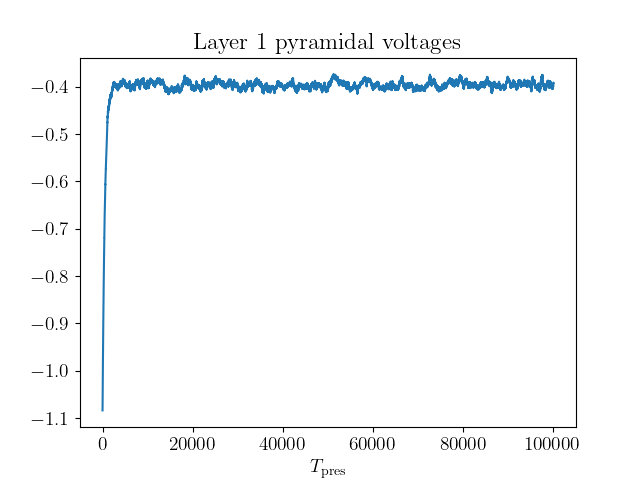

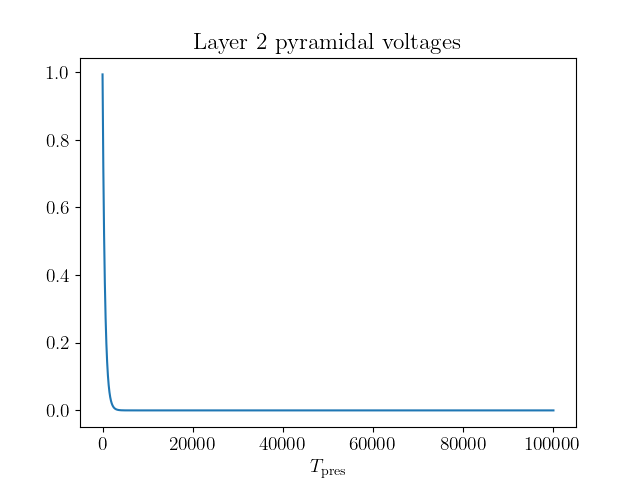

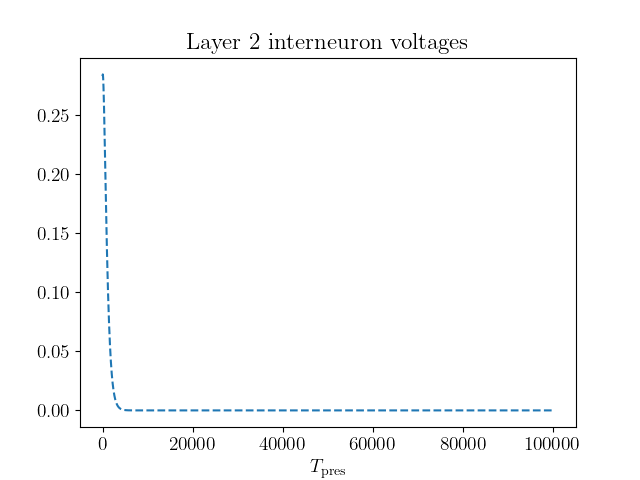

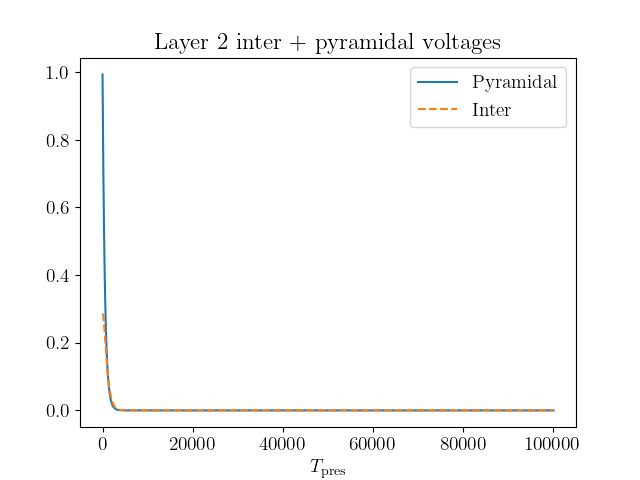

In [61]:
for i in range(len(layers[1:])):
    fig, ax = plt.subplots()
    uP = np.array([uP[i] for uP in uP_time_series])
    ax.plot(uP)
    plt.yscale('linear')
    label = '$T_{ \mathrm{pres}} $'
    plt.xlabel(label)
    plt.title(f'Layer {i+1} pyramidal voltages')
    plt.show()

fig, ax = plt.subplots()
uI = np.array(uI_time_series).reshape(-1, np.array(uI_time_series).shape[-1])
ax.plot(uI, '--')
plt.yscale('linear')
label = '$T_{ \mathrm{pres}} $'
plt.xlabel(label)
plt.title(f'Layer {len(layers)-1} interneuron voltages')
plt.show()

fig, ax = plt.subplots()
uP = np.array([uP[-1] for uP in uP_time_series])
ax.plot(uP, label='Pyramidal')
ax.plot(uI, '--', label='Inter')
plt.yscale('linear')
label = '$T_{ \mathrm{pres}} $'
plt.xlabel(label)
plt.title(f'Layer {len(layers)-1} inter + pyramidal voltages')
plt.legend()
plt.show()

In [62]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(len(BPI_time_series))
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(len(WIP_time_series))
                           ]))

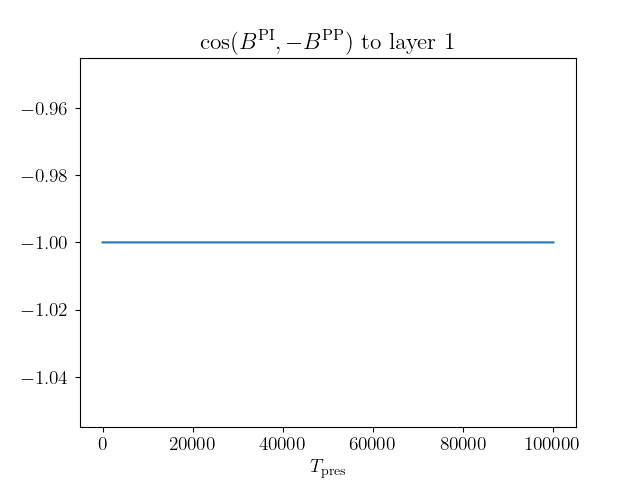

In [63]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '$T_{ \mathrm{pres}} $'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

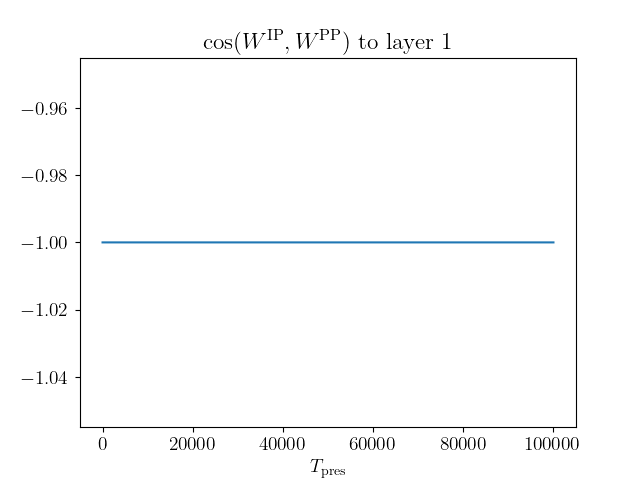

In [64]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '$T_{ \mathrm{pres}} $'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

In [68]:
WIP_time_series[-1]

[array([[1.65143654]])]

In [69]:
WIP_time_series[0]

[array([[1.65143654]])]

In [70]:
WPP_time_series[0][1]

array([[-0.57860025]])